# <p style="text-align: center;">TP2 - Do you need more signs?</p>

### **1. Import the Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image 
import os
from skimage.io import  imread, imshow 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

c:\Users\davic\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### **2. Load the Image Training and Test Datasets**

#### i. Get the Image Dataset Paths

In [2]:
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'

#### ii. Load Image Datasets 

We are going for the tiny version of the dataset!

In [3]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32
N_CLASS = 10

Loading the training dataset. Via DataGenerators

In [4]:
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()])
traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)

Split the Training Folder in Training / Validation

In [5]:
train_idx, valid_idx = train_test_split(
    range(len(traffic_signals_dataset)),
    test_size=0.1,
    shuffle=True,
    stratify=traffic_signals_dataset.targets
)

train_subset = Subset(traffic_signals_dataset, train_idx)
valid_subset = Subset(traffic_signals_dataset, valid_idx)

train_dataset_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
validation_dataset_loader = DataLoader(valid_subset, batch_size=64, shuffle=False)

In [6]:
def plot_distribution(dataset, ind=1):
    # visualize the  class distribution
    plt.figure(figsize=(5, 5))
    sns.barplot(data = pd.DataFrame.from_dict([dataset]).melt(), 
                x = "variable", y="value", hue="variable").set_title('Class Distribution of the dataset')

Training class distribution: {0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}


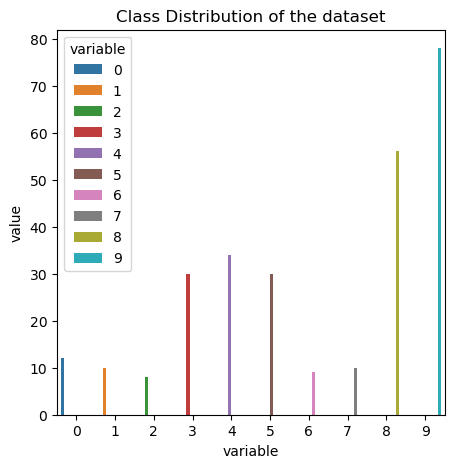

In [7]:
training_targets = traffic_signals_dataset.targets
t_targets = {k:0 for k in training_targets}
for t in training_targets:
    t_targets[t] += 1
print('Training class distribution:', t_targets)
plot_distribution(t_targets)

Loading the test dataset.

In [8]:
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

test_dataset_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [9]:
### subset version
labels = {value: key for key, value in traffic_signals_dataset.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in traffic_signals_dataset.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '38', 4: '39', 5: '44', 6: '46', 7: '49', 8: '50', 9: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 22: 'Cenas', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 46: 'Unknown', 49: 'Unk1', 50: 'Fences', 54: 'Do Not Park', 55: 'Do', 57: 'Forbidden'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 38 - Dangerous curve to the right
4 : 39 - Dangerous curve to the left
5 : 44 - Go left or straight
6 : 46 - Unknown
7 : 49 - Unk1
8 : 50 - Fences
9 : 6 - Speed limit (70km/h)
10


### **3. Plotting Sample Training Images**

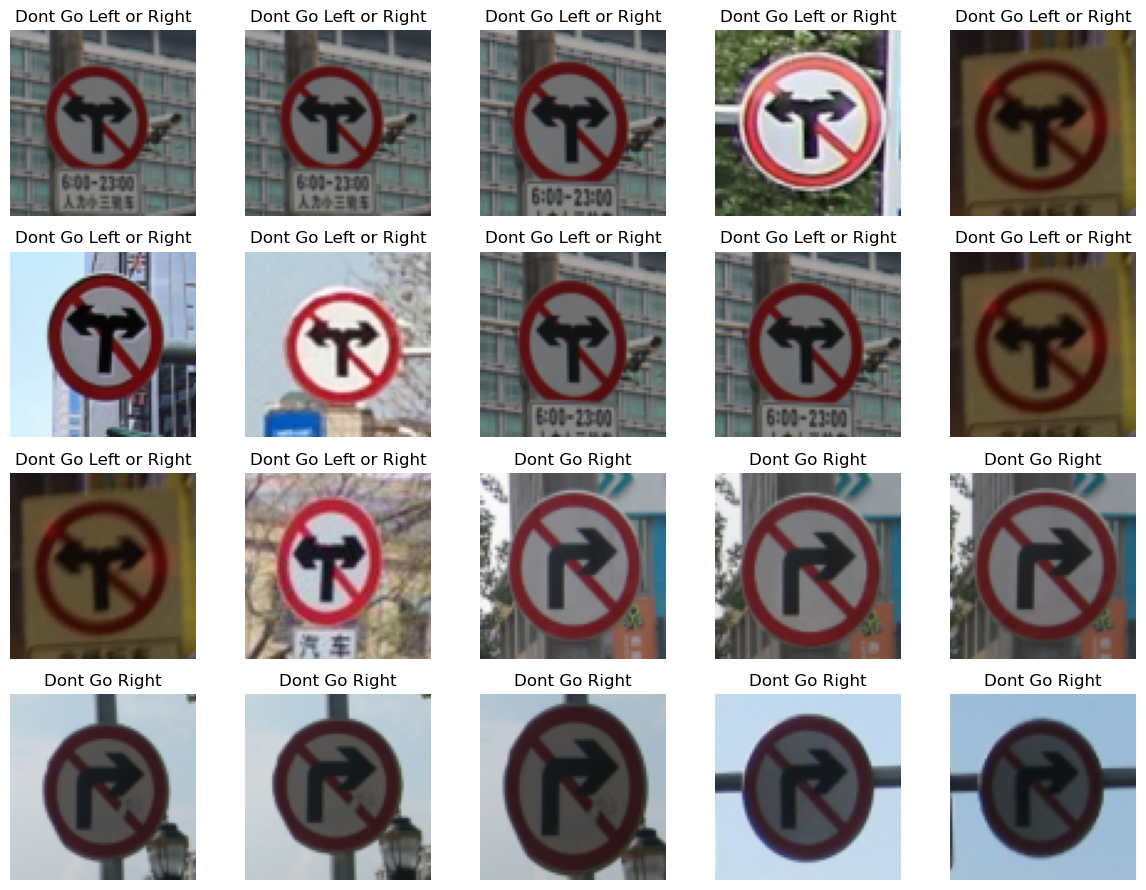

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(traffic_signals_dataset)
idx = 0

for i in range(4):
    for j in range(5):
        images, l = next(dataiter)
        img = images
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

In [11]:
def max_min_values(dataset, type=0):
    max_value = float('-inf')
    min_value = float('inf')

    for batch in dataset:
        images, _ = batch
        max_batch = images.max()
        min_batch = images.min()
        if max_batch > max_value:
            max_value = max_batch
        if min_batch < min_value:
            min_value = min_batch
        
    print("Maximum pixel value:", max_value)
    print("Minimum pixel value:", min_value)

In [12]:
# normalize the data 
max_min_values(train_dataset_loader) # train
max_min_values(validation_dataset_loader) # validation

print(images.shape)

Maximum pixel value: tensor(1.)
Minimum pixel value: tensor(0.)
Maximum pixel value: tensor(1.)
Minimum pixel value: tensor(0.)
torch.Size([3, 75, 75])


### **4. Data Augmentation**

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu") # Check a better way to train the model instead of the CPU
torch.manual_seed(42) # Using manual seed to ensure that results are reproducible
print(device)

cuda


In [ ]:
#TODO: get the accuracy of the model and plot the loss and the accuracy at the end

#### **Vector Quantized Variational Autoencoder (VQ-VAE)**

##### **Architecture**

In [15]:
# source: https://github.com/explainingai-code/VQVAE-Pytorch
class VQVAE(nn.Module):
    def __init__(self, color_channels=3, num_classes=10, latent_dim=128):
        super(VQVAE, self).__init__()
        
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(color_channels + num_classes, 16, 1, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 1, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        
        self.pre_quant_conv = nn.Conv2d(4, 2, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=latent_dim, embedding_dim=latent_dim)
        self.post_quant_conv = nn.Conv2d(2, 4, kernel_size=1)
        
        # Commitment Loss Beta
        self.beta = 0.2
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 1, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, color_channels, 1, stride=2, padding=1),
            nn.Sigmoid() # since the input are normalized between 0 and 1 we are using sigmoid, nn.Tanh() if the values were between -1 and 1,
        )   
        
    def forward(self, x, class_label):
        # B, C, H, W
        class_emb = self.embedding(class_label) # Embedding for the class label
        class_emb = class_emb.view(class_label.size(0), -1, 1, 1) # Reshape to match the spatial dimensions
        
        x = torch.cat([x, class_emb.expand(-1, -1, x.size(2), x.size(3))], dim=1) # Concatenate class embeddings with input image
        
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)
        
        ## Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))
        
        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))
        
        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))
        
        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss
        
        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()
        
        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        
        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        
        return output, quantize_losses

##### **Train**

In [16]:
def train(model, data_loader, num_epochs=50, device='cpu', type=1):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-3, 
                                weight_decay=1e-5)

    model = model.to(device)
    
    outputs = []
    for epoch in range(num_epochs):
        for (img, class_label) in data_loader: # THE OUTPUT SHOULD BE THE SAME AS THE INPUT
            img = img.to(device)
            class_label = class_label.to(device)
            
            # if you want to train to reconstruct a noise image you should add a little bit of noise and get the loss
            # Forward pass
            recon, quantize_loss = model(img, class_label)
                
            loss = criterion(recon, img)
            
            if type == 2:
                loss += quantize_loss
            
            # Back propagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
        outputs.append((epoch, img.to(device), recon.to(device)))
        
    
    return model.to(device), outputs

In [17]:
def generate_image(color_channels, model, num_samples):
    
    # Generate random noise
    noise = torch.randn(num_samples, color_channels, IMG_WIDTH, IMG_HEIGHT, device=device)

    with torch.no_grad():
        generated_images, _ = model.decoder(noise)
    
    # Process the output
    generated_images = generated_images.cpu().detach().numpy()  # Move to CPU and convert to numpy array

    # Plot the generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        image = generated_images[i].squeeze()  # Remove single-dimensional entries
        if len(image.shape) == 3:
            image = image.transpose(1, 2, 0)  # Transpose to (H, W, C) format for plotting
        axes[i].imshow(image, cmap='gray' if color_channels == 1 else None)
        axes[i].axis('off')
    plt.show()

    return generated_images

In [18]:
model = VQVAE()
num_epochs = 30
model, outputs = train(model, train_dataset_loader, num_epochs=num_epochs, device=device, type=2)

RuntimeError: Given groups=1, weight of size [16, 13, 1, 1], expected input[64, 131, 75, 75] to have 13 channels, but got 131 channels instead

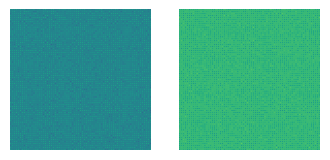

In [58]:
imgs_generated = generate_image(4, model, 2)

#### **Conditional Generative Adversarial Network**

##### **Architecture**

###### **Generator**

In [218]:
# architecture 1
class Generator(nn.Module):
    def __init__(self, latent_dim, channel_size=3):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(N_CLASS, latent_dim)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + latent_dim, 512, 3, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, channel_size, 7, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_emb_expanded = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((label_emb_expanded, noise), dim=1)  # Concatenate label embeddings and noise
        return self.model(input)

In [215]:
# architecture 2
class Generator(nn.Module):
    def __init__(self, latent_dim, channel_size=3):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(N_CLASS, latent_dim)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 5, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 6, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, channel_size, 7, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_emb_expanded = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((label_emb_expanded, noise), dim=1)  # Concatenate label embeddings and noise
        return self.model(input)

###### **Discriminator**

In [163]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(N_CLASS, IMG_WIDTH*IMG_HEIGHT)

        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # The output will be a probability
        )

    def forward(self, img, labels):
        label_embedding = self.label_embedding(labels).view(labels.size(0), 1, IMG_WIDTH, IMG_HEIGHT)
        input = torch.cat((img, label_embedding), 1)
        return self.model(input).view(-1, 1).squeeze(1)

##### **Train**

In [226]:
def train_CGAN(train_loader, num_epochs=10, device='cpu'):
    latent_dim = 128

    netG = Generator(latent_dim).to(device)
    netD = Discriminator().to(device)

    optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion = nn.BCELoss() # adversarial loss
    
    d_losses = []
    g_losses = []
    
    real_label = 1.0
    fake_label = 0.0
    
    # Training loop
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(train_loader):
            batch_size = imgs.size(0)
            
            real_img = imgs.to(device) # Real images (data) are moved to the device (e.g., GPU) for computation.
            real_labels = labels.to(device)
            
            # Adversarial ground truths
            valid_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device) # one to label "valid"/"real" images
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device) # zero to label fake images
            
            #-  Train Generator -#
            optimizerG.zero_grad() # Clears old gradients
            
            # Generate fake images
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device) # Randomly generated a sample from the latent space using a normal distribution with size=(imgs_size, latent_dim)
            ##print(z.shape)
            gen_labels = torch.randint(0, N_CLASS, (imgs.size(0),), device=device)
            gen_imgs = netG(z, gen_labels) # Generate images with `Generator`
            ##print(gen_imgs.shape)
            # Calculate the loss for the fake images - see how good the generator can fool the discriminator
            output = netD(gen_imgs, gen_labels)
            
            loss_g = criterion(output, valid_labels) # Compute the Loss for the generator
            D_G_z2 = output.mean().item()
            
            # Updates the weights of the Generator based on the gradients calculated.
            loss_g.backward()
            optimizerG.step()
            
            #-  Train Discriminator -#
            optimizerD.zero_grad()
            
            # Calculate the loss for the real images
            output = netD(real_img, real_labels)
            loss_d_real = criterion(output, valid_labels)
            D_x = output.mean().item()
            
            # Calculate the loss for the fake images - train the discriminator to predict fake images 
            output = netD(gen_imgs.detach(), gen_labels)
            loss_d_fake = criterion(output, fake_labels)
            D_G_z1 = output.mean().item()
            
            # Total discriminator loss
            loss_d = (loss_d_real + loss_d_fake) / 2
            
            # Updates the weights of the Discriminator based on the gradients calculated.
            loss_d.backward()
            optimizerD.step()
            
            # Output training stats
            if i % 100 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch+1, num_epochs, i+1, len(train_loader),
                    loss_d.item(), loss_g.item(), D_x, D_G_z1, D_G_z2))
                
            # Save outputs
            d_losses.append(loss_d.item())
            g_losses.append(loss_g.item())
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (((epoch % 50 == 0) and (i == 0)) or ((epoch == num_epochs-1) and (i == len(train_loader)-1))):
                class_names = ["Dont Go Left or Right", "Dont Go Right", "Go Right", "Dangerous curve to the right", "Dangerous curve to the left", "Go left or straight", "Unknown", "Unk1", "Fences", "Speed limit (70km/h)"]
                fig, axs = plt.subplots(1, N_CLASS, figsize=(75, 75))
                for c in range(N_CLASS):
                    z_g = torch.randn(1, latent_dim, 1, 1, device=device) # Sample noise
                    gen_labels_g = torch.full((1,), c, dtype=torch.long, device=device) # Generate image
                    with torch.no_grad():
                        img_out = netG(z_g, gen_labels_g)
                    
                    # Plot images
                    axs[c].imshow((img_out[0].permute(1, 2, 0).cpu().numpy()+ 1) / 2)
                    axs[c].axis('off')
                    axs[c].set_title(class_names[c])
                plt.show()
            
        print('Epoch', epoch+1, '- discriminator loss:', loss_d.item(), ' and generator loss:', loss_g.item())
    print(".Training complete.")
    return [netD, netG], [d_losses,g_losses]

[1/1000][1/4]	Loss_D: 0.7372	Loss_G: 0.6385	D(x): 0.5145	D(G(z)): 0.5378 / 0.5378


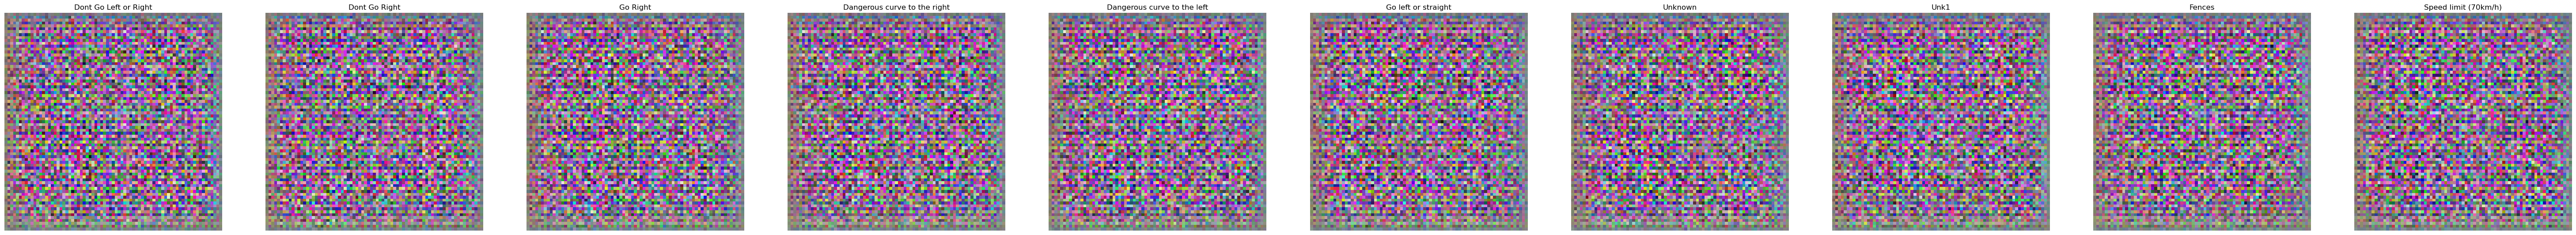

Epoch 1 - discriminator loss: 0.2359820157289505  and generator loss: 2.099447727203369
[2/1000][1/4]	Loss_D: 0.2882	Loss_G: 1.3409	D(x): 0.8773	D(G(z)): 0.3138 / 0.3138
Epoch 2 - discriminator loss: 0.19330079853534698  and generator loss: 2.0536720752716064
[3/1000][1/4]	Loss_D: 0.1554	Loss_G: 2.2499	D(x): 0.8479	D(G(z)): 0.1163 / 0.1163
Epoch 3 - discriminator loss: 0.26499447226524353  and generator loss: 1.2427361011505127
[4/1000][1/4]	Loss_D: 0.0879	Loss_G: 3.8883	D(x): 0.8747	D(G(z)): 0.0235 / 0.0235
Epoch 4 - discriminator loss: 0.13263104856014252  and generator loss: 4.848963737487793
[5/1000][1/4]	Loss_D: 0.0810	Loss_G: 3.1168	D(x): 0.9270	D(G(z)): 0.0695 / 0.0695
Epoch 5 - discriminator loss: 0.09378277510404587  and generator loss: 3.1950149536132812
[6/1000][1/4]	Loss_D: 0.3429	Loss_G: 0.8168	D(x): 0.9845	D(G(z)): 0.4654 / 0.4654
Epoch 6 - discriminator loss: 0.2474622130393982  and generator loss: 1.5655906200408936
[7/1000][1/4]	Loss_D: 0.1015	Loss_G: 3.7620	D(x): 0.88

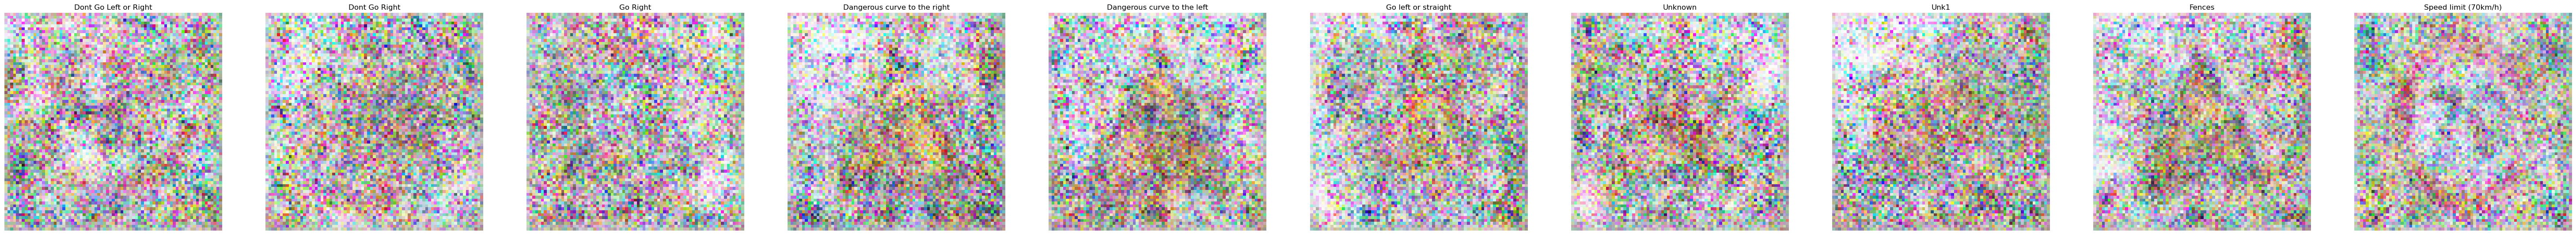

Epoch 101 - discriminator loss: 0.0023950410541146994  and generator loss: 6.308187484741211
[102/1000][1/4]	Loss_D: 0.0012	Loss_G: 8.0762	D(x): 0.9987	D(G(z)): 0.0012 / 0.0012
Epoch 102 - discriminator loss: 0.05492420494556427  and generator loss: 4.08207368850708
[103/1000][1/4]	Loss_D: 0.0050	Loss_G: 5.6233	D(x): 0.9958	D(G(z)): 0.0058 / 0.0058
Epoch 103 - discriminator loss: 0.004098820500075817  and generator loss: 7.396371841430664
[104/1000][1/4]	Loss_D: 0.0120	Loss_G: 4.1675	D(x): 0.9989	D(G(z)): 0.0225 / 0.0225
Epoch 104 - discriminator loss: 0.028262127190828323  and generator loss: 5.547842979431152
[105/1000][1/4]	Loss_D: 0.0046	Loss_G: 5.3458	D(x): 0.9971	D(G(z)): 0.0064 / 0.0064
Epoch 105 - discriminator loss: 0.016858670860528946  and generator loss: 6.491268634796143
[106/1000][1/4]	Loss_D: 0.0051	Loss_G: 5.7067	D(x): 0.9940	D(G(z)): 0.0043 / 0.0043
Epoch 106 - discriminator loss: 1.0152006149291992  and generator loss: 11.74976634979248
[107/1000][1/4]	Loss_D: 0.1116	

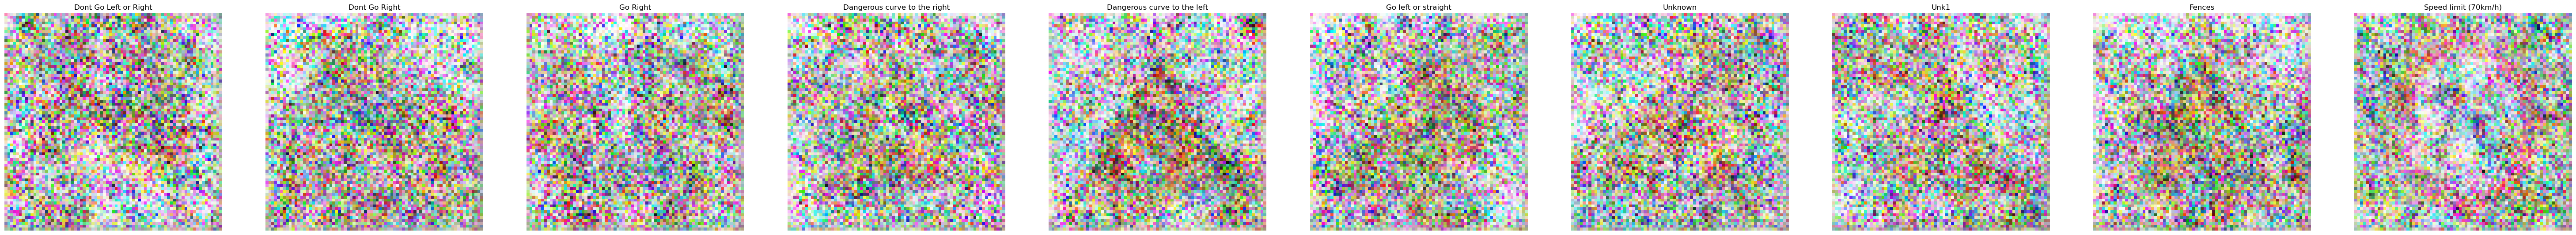

Epoch 201 - discriminator loss: 0.0817066952586174  and generator loss: 2.7551181316375732
[202/1000][1/4]	Loss_D: 0.0370	Loss_G: 12.0163	D(x): 0.9305	D(G(z)): 0.0000 / 0.0000
Epoch 202 - discriminator loss: 0.01750035397708416  and generator loss: 3.8145902156829834
[203/1000][1/4]	Loss_D: 0.0011	Loss_G: 8.8627	D(x): 0.9981	D(G(z)): 0.0003 / 0.0003
Epoch 203 - discriminator loss: 0.0037329373881220818  and generator loss: 7.695093154907227
[204/1000][1/4]	Loss_D: 0.0223	Loss_G: 5.9501	D(x): 0.9998	D(G(z)): 0.0407 / 0.0407
Epoch 204 - discriminator loss: 0.0019155533518642187  and generator loss: 6.421764850616455
[205/1000][1/4]	Loss_D: 0.0023	Loss_G: 6.1176	D(x): 0.9991	D(G(z)): 0.0037 / 0.0037
Epoch 205 - discriminator loss: 0.00048788235289976  and generator loss: 7.163154602050781
[206/1000][1/4]	Loss_D: 0.0034	Loss_G: 6.9667	D(x): 0.9943	D(G(z)): 0.0010 / 0.0010
Epoch 206 - discriminator loss: 0.0004876390448771417  and generator loss: 7.301936626434326
[207/1000][1/4]	Loss_D: 0.

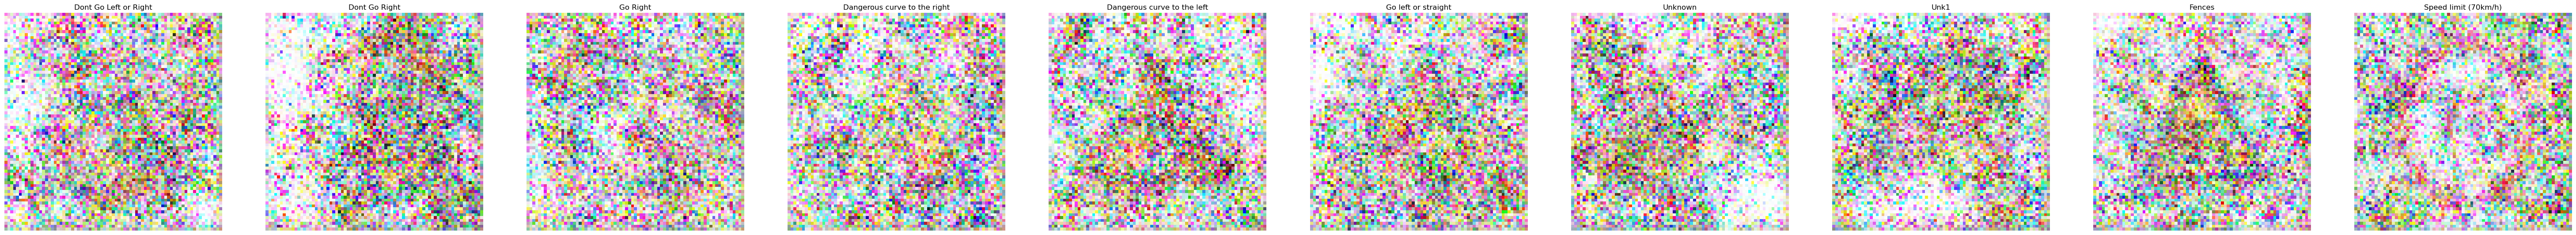

Epoch 301 - discriminator loss: 0.00025335242389701307  and generator loss: 8.180154800415039
[302/1000][1/4]	Loss_D: 0.0002	Loss_G: 12.7272	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
Epoch 302 - discriminator loss: 7.09708037902601e-05  and generator loss: 12.073469161987305
[303/1000][1/4]	Loss_D: 0.1245	Loss_G: 1.7912	D(x): 1.0000	D(G(z)): 0.2133 / 0.2133
Epoch 303 - discriminator loss: 0.00013735242828261107  and generator loss: 13.616497039794922
[304/1000][1/4]	Loss_D: 0.0033	Loss_G: 5.6568	D(x): 0.9994	D(G(z)): 0.0059 / 0.0059
Epoch 304 - discriminator loss: 0.006699657067656517  and generator loss: 10.328073501586914
[305/1000][1/4]	Loss_D: 0.0419	Loss_G: 15.2040	D(x): 0.9246	D(G(z)): 0.0000 / 0.0000
Epoch 305 - discriminator loss: 0.004932137206196785  and generator loss: 6.661291122436523
[306/1000][1/4]	Loss_D: 0.0221	Loss_G: 12.0380	D(x): 0.9572	D(G(z)): 0.0001 / 0.0001
Epoch 306 - discriminator loss: 0.05645525082945824  and generator loss: 2.347888708114624
[307/1000][1/4]	Los

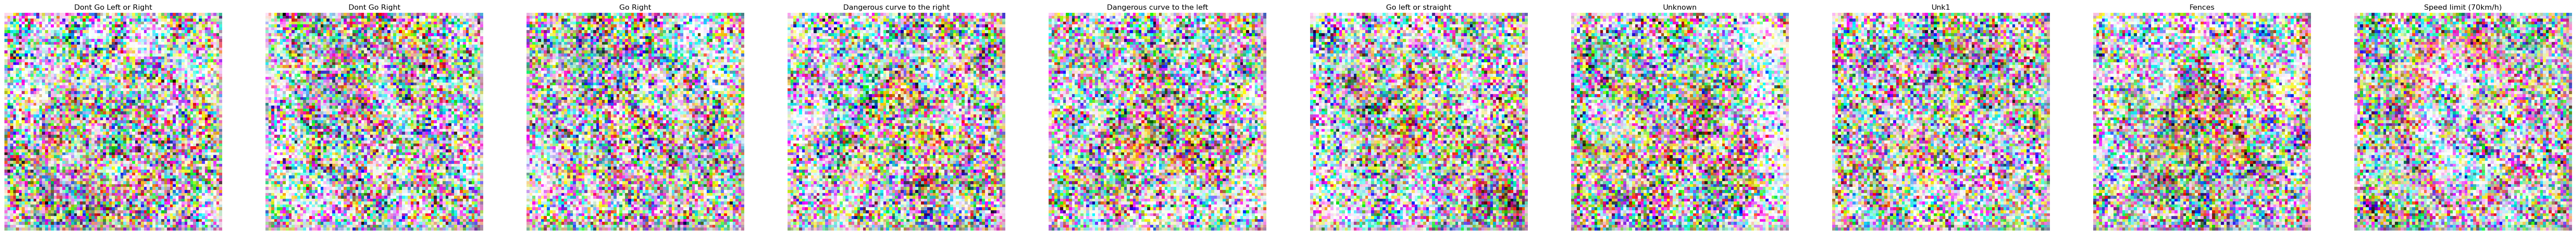

Epoch 401 - discriminator loss: 0.0005088893231004477  and generator loss: 10.742030143737793
[402/1000][1/4]	Loss_D: 0.0000	Loss_G: 15.3677	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch 402 - discriminator loss: 0.00018210230336990207  and generator loss: 9.548553466796875
[403/1000][1/4]	Loss_D: 0.0000	Loss_G: 10.1362	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
Epoch 403 - discriminator loss: 0.0020240815356373787  and generator loss: 8.981025695800781
[404/1000][1/4]	Loss_D: 0.0004	Loss_G: 8.5502	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003
Epoch 404 - discriminator loss: 5.399901419878006e-05  and generator loss: 12.377494812011719
[405/1000][1/4]	Loss_D: 0.0000	Loss_G: 15.5629	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch 405 - discriminator loss: 0.006632735021412373  and generator loss: 4.897616863250732
[406/1000][1/4]	Loss_D: 0.0002	Loss_G: 11.0255	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
Epoch 406 - discriminator loss: 0.07345447689294815  and generator loss: 10.921082496643066
[407/1000][1/4]	L

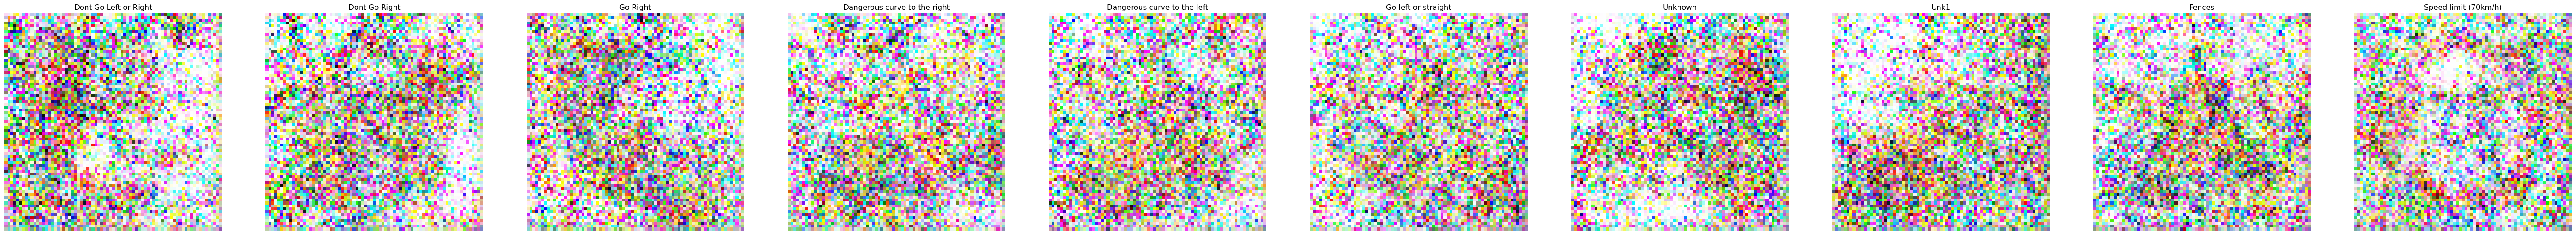

Epoch 501 - discriminator loss: 0.028132230043411255  and generator loss: 3.112722873687744
[502/1000][1/4]	Loss_D: 0.0005	Loss_G: 7.0622	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
Epoch 502 - discriminator loss: 8.021976827876642e-05  and generator loss: 17.637672424316406
[503/1000][1/4]	Loss_D: 0.0003	Loss_G: 11.7255	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
Epoch 503 - discriminator loss: 0.00013672752538695931  and generator loss: 13.404461860656738
[504/1000][1/4]	Loss_D: 0.0003	Loss_G: 13.2403	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
Epoch 504 - discriminator loss: 0.0018805136205628514  and generator loss: 5.837699890136719
[505/1000][1/4]	Loss_D: 0.0001	Loss_G: 9.8885	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
Epoch 505 - discriminator loss: 0.0004084029351361096  and generator loss: 8.086588859558105
[506/1000][1/4]	Loss_D: 0.0000	Loss_G: 10.4034	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
Epoch 506 - discriminator loss: 0.0004805520293302834  and generator loss: 11.818069458007812
[507/1000][1/4]	

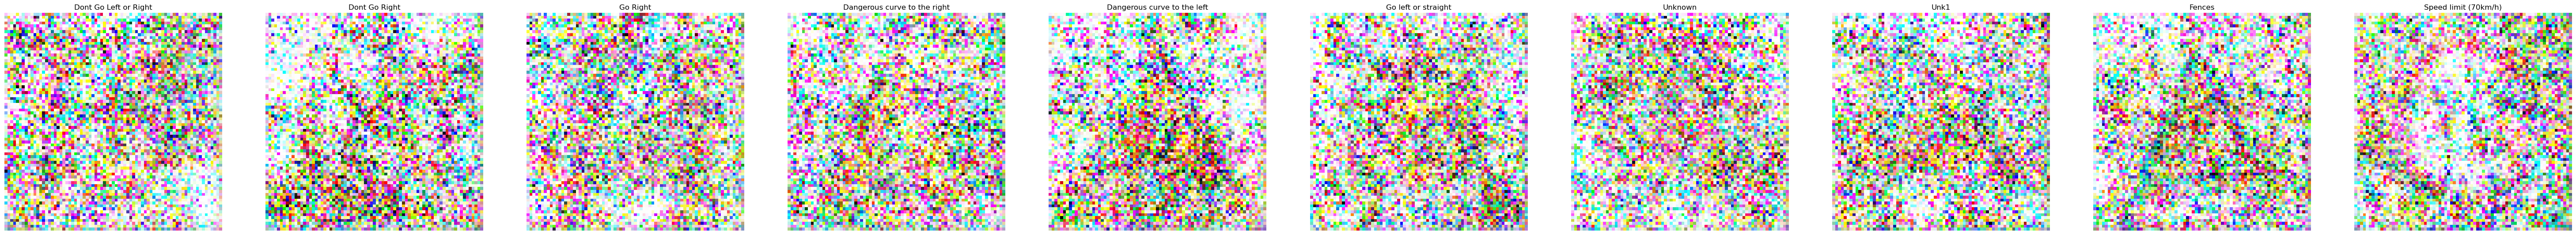

Epoch 601 - discriminator loss: 0.00016049345140345395  and generator loss: 11.625248908996582
[602/1000][1/4]	Loss_D: 0.0010	Loss_G: 6.5635	D(x): 1.0000	D(G(z)): 0.0019 / 0.0019
Epoch 602 - discriminator loss: 1.8543272744864225e-05  and generator loss: 13.144330024719238
[603/1000][1/4]	Loss_D: 0.0033	Loss_G: 5.4318	D(x): 1.0000	D(G(z)): 0.0066 / 0.0066
Epoch 603 - discriminator loss: 0.0003987113304901868  and generator loss: 7.485849857330322
[604/1000][1/4]	Loss_D: 0.0000	Loss_G: 13.3945	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch 604 - discriminator loss: 7.351625390583649e-05  and generator loss: 9.404343605041504
[605/1000][1/4]	Loss_D: 0.0002	Loss_G: 9.8998	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
Epoch 605 - discriminator loss: 0.05164286866784096  and generator loss: 2.6152150630950928
[606/1000][1/4]	Loss_D: 0.0000	Loss_G: 14.3015	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch 606 - discriminator loss: 0.005991681013256311  and generator loss: 5.099753379821777
[607/1000][1/4]	Lo

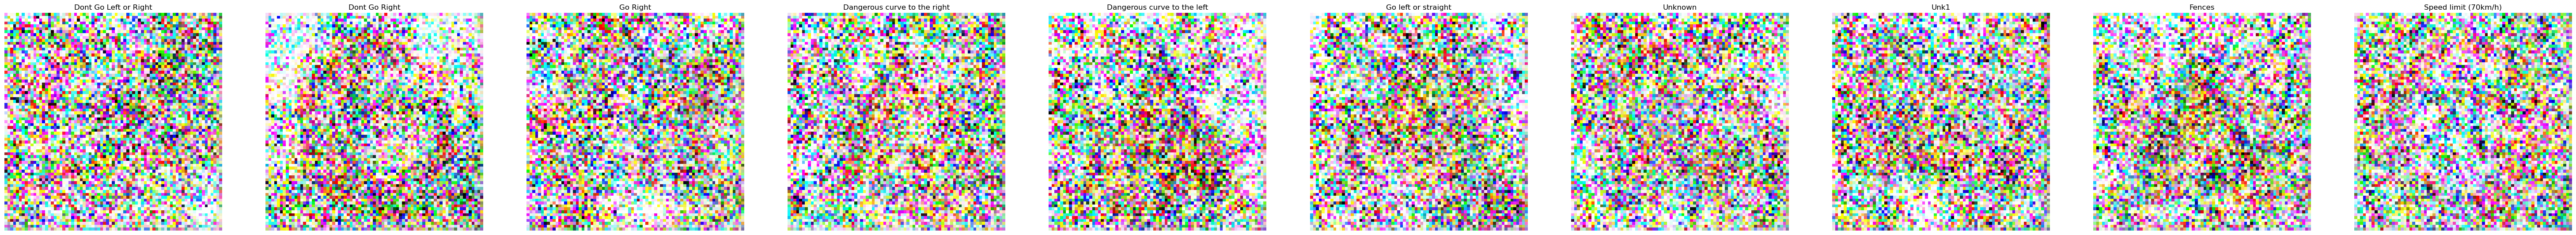

Epoch 701 - discriminator loss: 6.443287475121906e-06  and generator loss: 13.391556739807129
[702/1000][1/4]	Loss_D: 0.0000	Loss_G: 11.7365	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch 702 - discriminator loss: 0.0007556886994279921  and generator loss: 14.033684730529785
[703/1000][1/4]	Loss_D: 0.0001	Loss_G: 10.3894	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
Epoch 703 - discriminator loss: 0.001838910742662847  and generator loss: 5.814942359924316
[704/1000][1/4]	Loss_D: 0.0001	Loss_G: 10.4939	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
Epoch 704 - discriminator loss: 9.543302439851686e-05  and generator loss: 8.775863647460938
[705/1000][1/4]	Loss_D: 0.0001	Loss_G: 11.9239	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
Epoch 705 - discriminator loss: 0.005613023415207863  and generator loss: 4.686465740203857
[706/1000][1/4]	Loss_D: 0.0001	Loss_G: 8.9987	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
Epoch 706 - discriminator loss: 9.285385203838814e-06  and generator loss: 17.26469612121582
[707/1000][1/4]	Lo

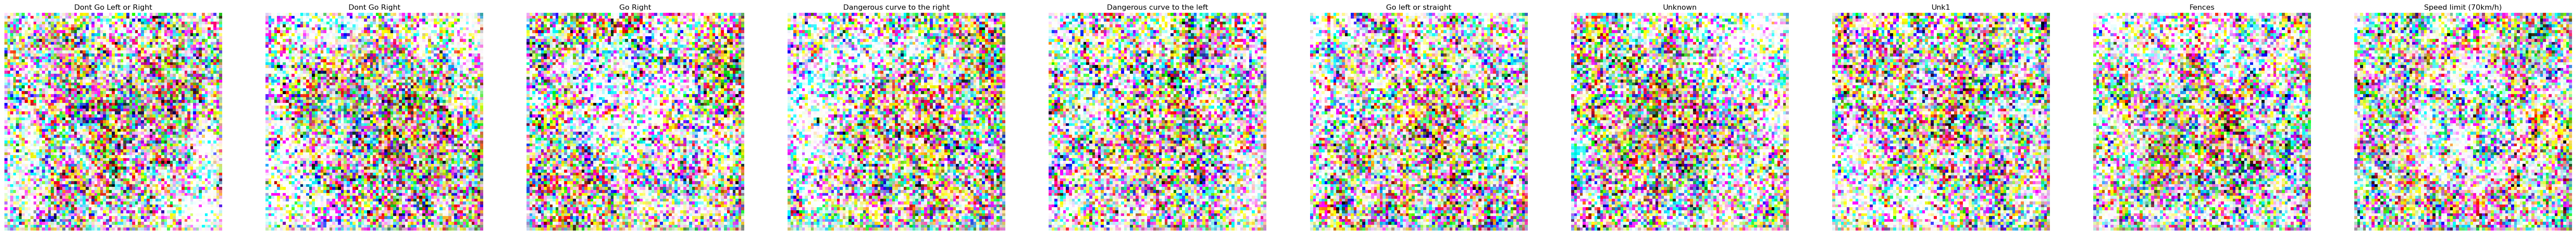

Epoch 801 - discriminator loss: 7.103360258042812e-05  and generator loss: 10.637484550476074
[802/1000][1/4]	Loss_D: 0.0000	Loss_G: 11.3468	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
Epoch 802 - discriminator loss: 0.0002527152537368238  and generator loss: 8.539321899414062
[803/1000][1/4]	Loss_D: 0.0020	Loss_G: 6.6001	D(x): 1.0000	D(G(z)): 0.0040 / 0.0040
Epoch 803 - discriminator loss: 5.371244697016664e-05  and generator loss: 12.180938720703125
[804/1000][1/4]	Loss_D: 0.0001	Loss_G: 10.0700	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
Epoch 804 - discriminator loss: 0.0022269345354288816  and generator loss: 5.897321701049805
[805/1000][1/4]	Loss_D: 0.0000	Loss_G: 12.1674	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
Epoch 805 - discriminator loss: 2.779769420158118e-05  and generator loss: 11.052268028259277
[806/1000][1/4]	Loss_D: 0.0004	Loss_G: 8.1964	D(x): 0.9997	D(G(z)): 0.0005 / 0.0005
Epoch 806 - discriminator loss: 0.0002864607085939497  and generator loss: 11.190826416015625
[807/1000][1/4]

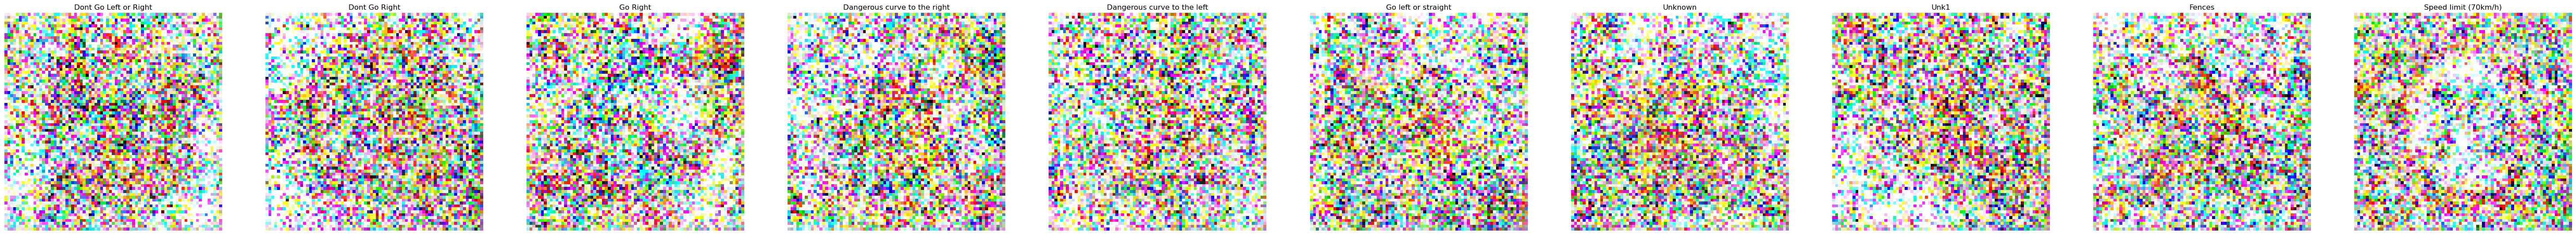

Epoch 901 - discriminator loss: 0.0008895752835087478  and generator loss: 10.37170696258545
[902/1000][1/4]	Loss_D: 0.1029	Loss_G: 3.2325	D(x): 1.0000	D(G(z)): 0.1336 / 0.1336
Epoch 902 - discriminator loss: 0.03851631283760071  and generator loss: 17.43948745727539
[903/1000][1/4]	Loss_D: 0.0007	Loss_G: 15.0889	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
Epoch 903 - discriminator loss: 0.0009788580937311053  and generator loss: 7.279672145843506
[904/1000][1/4]	Loss_D: 0.0001	Loss_G: 11.7104	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
Epoch 904 - discriminator loss: 7.296574767678976e-05  and generator loss: 10.770645141601562
[905/1000][1/4]	Loss_D: 0.2688	Loss_G: 18.1188	D(x): 0.7010	D(G(z)): 0.0000 / 0.0000
Epoch 905 - discriminator loss: 0.010833146050572395  and generator loss: 12.325465202331543
[906/1000][1/4]	Loss_D: 0.0094	Loss_G: 10.9852	D(x): 0.9992	D(G(z)): 0.0170 / 0.0170
Epoch 906 - discriminator loss: 0.08658909052610397  and generator loss: 10.04034423828125
[907/1000][1/4]	Loss_

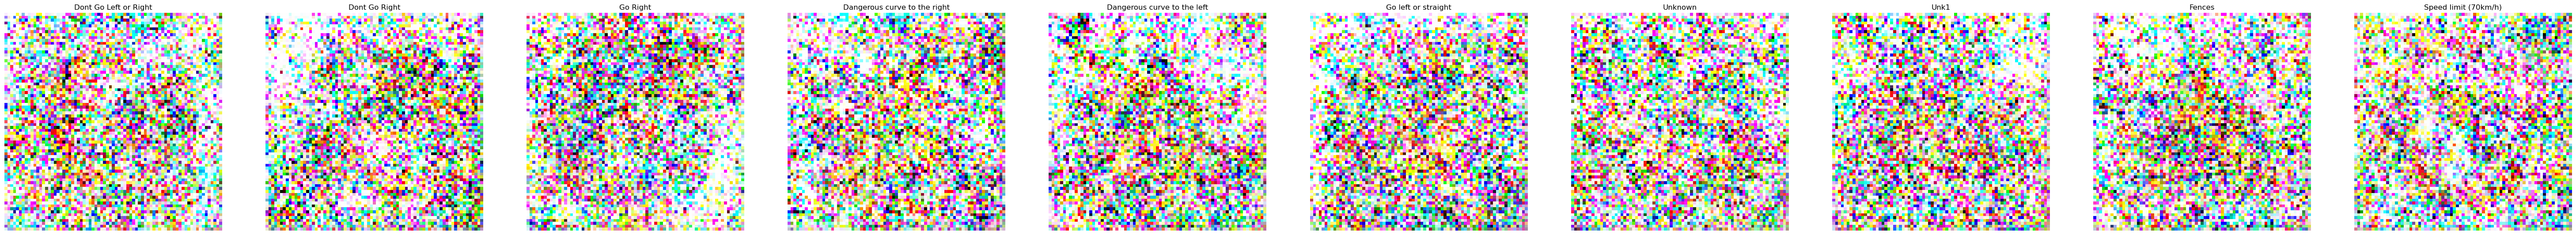

Epoch 1000 - discriminator loss: 7.279883720912039e-05  and generator loss: 11.861328125
.Training complete.


In [228]:
num_epochs = 1000
models, outputs = train_CGAN(train_dataset_loader, num_epochs=num_epochs, device=device)

#### **Diffusion model**

### **5. Model for Image Classification**

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, img_width, img_height, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, padding='valid')
        self.bn1 = nn.BatchNorm2d(num_features=128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='valid', bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        #self.fc1 = nn.Linear(32 * self._conv_output_shape(img_width, img_height), 256)  # Assuming square input for simplification
        self.fc1 = nn.Linear(1568,256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
        # L2 regularization is not directly included in layers in PyTorch, 
        # it's typically added to the optimizer during the training step.

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def _conv_output_shape(self, img_width, img_height, kernel_size=3, stride=1, padding=0, dilation=1):
        h = ((img_height + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        w = ((img_width + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        return int(h/8) * int(w/8)  # Considering three max pooling layers with kernel_size=2, stride=2

In [ ]:
def train_model(model, criterion, optimizer,train_dataset_loader, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        cumulative_loss = 0
        for batch_idx, (data, target) in enumerate(train_dataset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            #if (batch_idx + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {batch_idx+1}/{len(train_dataset_loader)}, Loss: {loss.item():.4f}')
            cumulative_loss += loss.item()
        print(f"Epoch {epoch+1} average loss: {cumulative_loss/len(train_dataset_loader)}")
    return model.to("cpu")

In [ ]:
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")

num_classes = len(labels)
print(num_classes)
print(device)
num_epochs = 15
model = CustomCNN(IMG_WIDTH, IMG_HEIGHT, num_classes)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
TRAIN_MODEL = False
if TRAIN_MODEL:
    ccnn = train_model(model, criterion, optimizer, train_dataset_loader, num_epochs, device)
    
else:
    ccnn = torch.load('baseline_model.pth')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def test_model(model, dataset_loader):
    y_real = []
    y_pred = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataset_loader:
            y_real.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the {} test images: {} %'.format(total,100 * correct / total))
    # Generate the confusion matrix
    cm = confusion_matrix(y_real, y_pred)
    
    #TODO put others evaluation metrics

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [ ]:
print(test_model(ccnn, validation_dataset_loader))